In [12]:
#SET GLOBAL VARS AND IMPORTS
import sys
sys.path.append("..")

from mtg_experimentation_utilities import *
from Agents import *
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

draft_str='C:/Users/trist/OneDrive/Documents/draft_data_public.VOW.PremierDraft.csv'

#In addition to setting up the agents/baselines for each experiment you will need each of the following
dirpath = "C:/Users/trist/OneDrive/Desktop/drafting-research/"


In [13]:
def pull_user_info_from_dump(draft_str,n_rows=420000):
    """Given the dump file, extract the user information for n rows of the dataframe so we can further analyze 
    who was making these decisions that fall in/out of line with our bots"""

    df = pd.read_csv(draft_str, nrows=n_rows)

    df = df.iloc[:,0:9]

    df = df.drop_duplicates(keep="first", inplace=False)

    return df

def get_accuracy_scores(df:pd.DataFrame,cutoff:int=0):
    """Print out the accuracy scores across all drafts in a file for each agent at the 
    draft-id level"""

    #generate accumalator and df copy 
    colnames=[]
    df2=df.copy()

    #Since real is the first column after the archnames, we will use it to pull the columns that we want
    real_posn = list(df2.columns).index('Real')

    #For each agent, format the new column and see if each pick in the draft was accurate enough to count 
    #given the threshold
    for c in df2.iloc[:,:real_posn].columns:
        string = c + '_accurate_t{}'.format(str(cutoff))
        df2[string] = np.where(df2[c + "_picks_off"]<cutoff,1,0)
        colnames.append(string)

    #reduce to just the columns we created for a clean printout
    df2 = df2.loc[:,colnames]

    print(df2.mean())

def get_grouped_accuracy_df(df:pd.DataFrame,dump:object,cutoff:int=0, as_percent:bool=False):
    """Generate a dataframe that gives the accuracies per agent for a certain accuracy threshold grouped at the 
    draft-id level. Also adds in the winrate from the draft dump for analysis of features in the dump alongside 
    simulation data"""

    #generate accumalator and df copy 
    colnames=[]
    df2=df.copy()
    
    #Since real is the first column after the archnames, we will use it to pull the columns that we want
    real_posn = list(df2.columns).index('Real')
    for c in df2.iloc[:,:real_posn].columns:
        string = c + '_accurate_t{}'.format(str(cutoff))
        df2[string] = np.where(df2[c + "_picks_off"]<cutoff,1,0)
        colnames.append(string)
    colnames.append('id')

    #If you want percentages vs the sum of correct picks, divide by the # of picks in a draft (e.g 28 correct picks or 28/42 = 66.66% accuracy)
    if as_percent==True:
        df2 = df2.loc[:,colnames].groupby('id').mean()

    else:
        df2 = df2.loc[:,colnames].groupby('id').sum()

    df2['rowmax'] = df2.max(axis=1)
    df2['name_max'] = df2.idxmax(axis=1)

    #rename the id column in the dump so we can merge in the features from the dump
    dump.rename(columns={"draft_id":'id'},inplace=True)
    df2 = dump.merge(df2,"inner","id")

    #Create a winrate feature as it may be relevant
    df2['winrate'] = df2['event_match_wins'] / (df2['event_match_wins'] + df2['event_match_losses'])

    return df2

def open_index_file_and_preprocess(index_file_path:str,source_weights_file_path:str,archetypes:list=['WU','WB','WR','WG','UB','UR','UG','BR','BG','RG']):
    """Engineer all the features that we had in the other 3 filetypes, but do that from 1 source
    file to reduce clutter in the repository. Given an index file, generate t1, t3, accuracies.
    
    OUTPUT: Df containing raw data for picks off, norm delta, bot score residual, t1 accuracy boolean, t3 accuracy boolean,
    for each pick of each draft.There is one column for each of these per bot in the simulation (e.g. norm delta, picks off, accuracy for bot x),
    so our data can get a bit wide. We can use regex search on the column names to pull out the subsets most relevant to our analysis (or future feature
    engineering). Currently, some common analyses here would be to:
    regex on t1_match (and create a column by cloning the id column and other relevant attributes from the original df) for t1 accuracy analysis
    regex on picks off (and create necessary columns by cloning from source df) for understanding how good the bots are at each pick (can do this for norm + residual too)


    Can join in data from the dump file to include win rates etc using the ID column for cross-sectional
    analysis, and can join colors in given the weights source file. Since all of our source weight files have a convenient color column,
    we can just use any of those files from the same set to get our weight columns without having to parse the set's JSON file"""

    df = pd.read_csv(index_file_path)

    #Iterate through each of our picks off columns to get the agent name (in theory could've been done w/ any other autogenerated column,
    #since we can strip the suffix off whatever column as long as there is 1 per bot)
    for x in list(df.filter(regex='picks_off').columns): 

        #Set each column to numeric before doing the number matching here
        df[x] = df[x].apply(pd.to_numeric, errors='coerce')

        #Strip out the picks off part of the column name to get our agents themselves
        x_str = x.replace('_picks_off','')

        #Dynamically make t1 accuracy columns and names for the cols
        t1_string = (x_str + "_t1_match")
        df[t1_string] = np.where(df[x]==0,1,0)

        #Dynamically make t3 accuracy columns
        t3_string = (x_str + "_t3_match")
        df[t3_string] = np.where(df[x]<=3,1,0)

    #Now, let's add in the colors for each card in the dataset from our source weights file
    source_df = pd.read_csv(source_weights_file_path)

    colors = source_df['Color'].reset_index()

    #Pull out the item from the colors index corresponding with the real pick
    df['Real_colors'] = df.apply(lambda x: colors['Color'].iloc[x['Real']], axis=1)

    #Replace nan with a single character N, so we can do single character color matching later
    df['Real_colors'].replace({np.nan:"N"}, inplace=True)

    for a in archetypes:
        df[a] = np.where(df["Real_colors"].isin(list(a)),1,0)

    return df

## Human Pick Comparison Experiment Workflow
Do the following, and you will be able to run experiments comparing complete drafts in our 17lands dump to what the agents would've picked given the pool at a each pick

In [14]:
#Put together lists of instantiated agents that you want to put experiments together with
agents = [Med_Agent(arch_prefs=[0]),
Med_Agent(arch_prefs=[1]),
Med_Agent(arch_prefs=[2]),
Med_Agent(arch_prefs=[3]),
Med_Agent(arch_prefs=[4]),
Med_Agent(arch_prefs=[5]),
Med_Agent(arch_prefs=[6]),
Med_Agent(arch_prefs=[7]),
Med_Agent(arch_prefs=[8]),
Med_Agent(arch_prefs=[9]),
Hard_Agent(),
Force_K_Agent(k_forced=5),
Basic_Agent()]

standard_agents = [
Med_Agent(arch_prefs=[7]),
Greedy_Agent(), 
Hard_Agent(),
Force_K_Agent(k_forced=1),
Basic_Agent()]

#Put our weights file name in a variable (the function will handle the filepath work)
weights = 'weights_data/processed_weights/VOM_weights_seen_rates.csv'

#If running more than 1 experiment, it may be good to write dictionaries and split everything out to ensure accuracy
dicts = [{'suffix':"Standard",
'draft_str':draft_str,
'agents':standard_agents,
'n_iter':1000
},

{'suffix':"Medium",
'draft_str':draft_str,
'agents':agents,
'n_iter':1000
}]

#If you want to run multiple experiments with the same weights file; this function is in the experimentation utilities python module
#human_pick_experiment_runner(dicts,weights)

#If you want to run a single experiment; this function is in the experimentation utilities python module
run_human_pick_experiment("TEST",draft_str,dirpath,weights,agents,10)

Below, we will pull the two dfs we need to join in real player data and to process our human pick comparison data

In [15]:
dump = pull_user_info_from_dump(draft_str)

## Analysis #1 single-archetype medium bot performance comparison
Here, we want to see if the single arch medium bots tend to do well in this set

In [16]:
df = open_index_file_and_preprocess(dirpath+"index_data/VOM_weights_seen_rates_1000_Medium.csv", dirpath+"weights_data/source_weights/VOM_Weights_default__seen_rates_df.csv")

In [17]:
#df = open_index_file_and_preprocess(dirpath+"index_data/VOM_weights_seen_rates_10_TEST.csv", dirpath+"weights_data/source_weights/VOM_Weights_default__seen_rates_df.csv")

In [18]:
print('Overall Accuracies on Picks in Medium Experiment')
get_accuracy_scores(df,1)

Overall Accuracies on Picks in Medium Experiment
med_agent_archs_WU__accurate_t1                           0.329922
med_agent_archs_WB__accurate_t1                           0.351916
med_agent_archs_WR__accurate_t1                           0.345601
med_agent_archs_WG__accurate_t1                           0.304152
med_agent_archs_UB__accurate_t1                           0.332438
med_agent_archs_UR__accurate_t1                           0.329873
med_agent_archs_UG__accurate_t1                           0.302676
med_agent_archs_BR__accurate_t1                           0.360651
med_agent_archs_BG__accurate_t1                           0.313928
med_agent_archs_RG__accurate_t1                           0.311363
hard_agent_8_16_bstart_5_bplateau_1_linear_accurate_t1    0.508735
force_k_agent_k_5_accurate_t1                             0.480352
basic_agent_accurate_t1                                   0.519623
dtype: float64


In [19]:
proc_weights = pd.read_csv(dirpath+'weights_data/processed_weights/VOM_weights_seen_rates.csv')
#Below is the order of archetypes in the weight file

# 'Seen_rate_WU', 'Seen_rate WB', 'Seen_rate WR', 'Seen_rate WG',
#        'Seen_rate UB', 'Seen_rate UR', 'Seen_rate UG', 'Seen_rate BR',
#        'Seen_rate BG', 'Seen_rate RG'

#Based on the order above, we can see that the strongest archetype in the set is positiion 7 (which is BR)
proc_weights.sum()

0    33.468085
1    32.890046
2    17.753898
3    20.672841
4    31.375662
5    26.148927
6    12.371192
7    48.343629
8    17.839027
9    35.606125
dtype: float64

Based on the power scaling from our weights file, we should not be surprised that the best medium bot is for the color with the largest norm. We also see a drastic drop-off from even the best single-arch approach relative to the basic or forcing or hard bots (really most of our agents still beat this strategy). However, we also need to see the effect this will have on classification. 

In [20]:
dfz = get_grouped_accuracy_df(df,dump,1, as_percent=True)
dfz

,user_match_win_rate_bucket,user_n_matches_bucket,id,draft_time,expansion,event_type,user_rank,event_match_wins,event_match_losses,med_agent_archs_WU__accurate_t1,...,med_agent_archs_UG__accurate_t1,med_agent_archs_BR__accurate_t1,med_agent_archs_BG__accurate_t1,med_agent_archs_RG__accurate_t1,hard_agent_8_16_bstart_5_bplateau_1_linear_accurate_t1,force_k_agent_k_5_accurate_t1,basic_agent_accurate_t1,rowmax,name_max,winrate
0,0.68,50,aea51b3b64294e07bd00c6f5d1c82991,2021-11-14 12:37:39,VOW,PremierDraft,gold,0,3,0.642857,...,0.261905,0.166667,0.119048,0.166667,0.476190,0.404762,0.476190,0.642857,med_agent_archs_WU__accurate_t1,0.000000
1,0.68,50,d4acd0639a54445f803c015e1f7fa55b,2021-11-14 13:22:29,VOW,PremierDraft,gold,2,3,0.333333,...,0.404762,0.285714,0.333333,0.166667,0.428571,0.428571,0.428571,0.666667,med_agent_archs_UB__accurate_t1,0.400000
2,0.68,50,d5b64aba6893447b987b29ac081e970d,2021-11-17 18:47:54,VOW,PremierDraft,gold,7,0,0.166667,...,0.380952,0.190476,0.666667,0.404762,0.428571,0.357143,0.404762,0.666667,med_agent_archs_BG__accurate_t1,1.000000
3,0.68,50,40f1b91abc764b9eaf423b871ae47a10,2021-11-22 13:45:23,VOW,PremierDraft,platinum,6,3,0.690476,...,0.333333,0.190476,0.166667,0.142857,0.571429,0.523810,0.595238,0.690476,med_agent_archs_WU__accurate_t1,0.666667
4,0.68,50,eb91bb001aec49caacee7ef7d6c6c2a1,2021-11-23 22:23:02,VOW,PremierDraft,platinum,7,1,0.190476,...,0.142857,0.690476,0.404762,0.166667,0.642857,0.642857,0.666667,0.690476,med_agent_archs_BR__accurate_t1,0.875000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
979,0.60,100,4159baa0f2f34dbc91db86428d1a3863,2021-11-23 08:27:49,VOW,PremierDraft,mythic,0,3,0.142857,...,0.333333,0.285714,0.642857,0.261905,0.309524,0.357143,0.333333,0.642857,med_agent_archs_BG__accurate_t1,0.000000
980,0.60,100,63c59c21306146099ab51f04f503ebd5,2021-11-26 03:33:22,VOW,PremierDraft,mythic,4,3,0.261905,...,0.119048,0.380952,0.190476,0.404762,0.523810,0.452381,0.523810,0.642857,med_agent_archs_WR__accurate_t1,0.571429
981,0.60,100,280c65fc09634156af3449d02edab600,2021-11-26 14:18:01,VOW,PremierDraft,mythic,7,2,0.285714,...,0.666667,0.166667,0.428571,0.380952,0.261905,0.238095,0.261905,0.666667,med_agent_archs_UG__accurate_t1,0.777778
982,0.60,100,041acc2932ca405c823a4def69752afe,2021-12-03 06:48:37,VOW,PremierDraft,diamond,6,3,0.619048,...,0.333333,0.166667,0.142857,0.214286,0.452381,0.357143,0.428571,0.619048,med_agent_archs_WU__accurate_t1,0.666667


In [21]:
print("Percent Shares of Strategies in the Medium Experiment")
dfz.groupby('name_max').agg({'name_max':'count',
"rowmax": ['min','max','mean']})['name_max','count']/len(dfz)

Percent Shares of Strategies in the Medium Experiment


name_max
basic_agent_accurate_t1                                   0.037602
force_k_agent_k_5_accurate_t1                             0.019309
hard_agent_8_16_bstart_5_bplateau_1_linear_accurate_t1    0.052846
med_agent_archs_BG__accurate_t1                           0.053862
med_agent_archs_BR__accurate_t1                           0.121951
med_agent_archs_RG__accurate_t1                           0.094512
med_agent_archs_UB__accurate_t1                           0.114837
med_agent_archs_UG__accurate_t1                           0.045732
med_agent_archs_UR__accurate_t1                           0.081301
med_agent_archs_WB__accurate_t1                           0.116870
med_agent_archs_WG__accurate_t1                           0.071138
med_agent_archs_WR__accurate_t1                           0.080285
med_agent_archs_WU__accurate_t1                           0.109756
Name: (name_max, count), dtype: float64

In [22]:
print("Summary Stats for Medium Experiment")
dfz.groupby('name_max').agg({'name_max':'count',
"rowmax": ['min','max','mean']})

Summary Stats for Medium Experiment


name_max    rowmax  \
                                                      count       min   
name_max                                                                
basic_agent_accurate_t1                                  37  0.523810   
force_k_agent_k_5_accurate_t1                            19  0.452381   
hard_agent_8_16_bstart_5_bplateau_1_linear_accu...       52  0.428571   
med_agent_archs_BG__accurate_t1                          53  0.452381   
med_agent_archs_BR__accurate_t1                         120  0.452381   
med_agent_archs_RG__accurate_t1                          93  0.476190   
med_agent_archs_UB__accurate_t1                         113  0.428571   
med_agent_archs_UG__accurate_t1                          45  0.404762   
med_agent_archs_UR__accurate_t1                          80  0.428571   
med_agent_archs_WB__accurate_t1                         115  0.452381   
med_agent_archs_WG__accurate_t1                          70  0.404762   
med_agent_archs_WR__accurate_t1                          79  0.476190   
med_agent_archs_WU__accurate_t1                         108  0.452381   

                                                                        
                                                         max      mean  
name_max                                                                
basic_agent_accurate_t1                             0.833333  0.658945  
force_k_agent_k_5_accurate_t1                       0.690476  0.583960  
hard_agent_8_16_bstart_5_bplateau_1_linear_accu...  0.785714  0.636447  
med_agent_archs_BG__accurate_t1                     0.761905  0.638365  
med_agent_archs_BR__accurate_t1                     0.857143  0.672421  
med_agent_archs_RG__accurate_t1                     0.857143  0.660010  
med_agent_archs_UB__accurate_t1                     0.833333  0.630636  
med_agent_archs_UG__accurate_t1                     0.785714  0.626984  
med_agent_archs_UR__accurate_t1                     0.833333  0.654167  
med_agent_archs_WB__accurate_t1                     0.880952  0.661698  
med_agent_archs_WG__accurate_t1                     0.880952  0.628912  
med_agent_archs_WR__accurate_t1                     0.833333  0.648583  
med_agent_archs_WU__accurate_t1                     0.904762  0.658069

Looking at the classification breakdown, we see that large chunks of the population can be covered by the medium bots for BR, UB, and WB. The non-medium agents account for 108/984 = ~11% of the outcomes when we look at all of the archetypes in single lists. At the same time, this should not be surprising since decks that most closely align with an archetype would be classified under the medium agent for that archetype irrespective of the actual strategy.

### Testing the Idea that Pools Containing Archetypes Line Up with Those Instantiated in the Medium Agents

Below, we will take a look at which colors the cards selected contain and how those relate to the strongest archetype selected by the agent

In [23]:
#In this cell, we will replace the index of the pick with a color and find the most common arch/#cards in teh most common arch per draft id
archetypes = ['WU','WB','WR','WG','UB','UR','UG','BR','BG','RG']
perf_df_grouped = df.groupby('id')[archetypes].sum().reset_index()
perf_df_grouped.iloc[:,1:]
perf_df_grouped['top_arch_count'] = perf_df_grouped.iloc[:,-11:].max(axis=1)/42
perf_df_grouped['top_arch_name'] = perf_df_grouped.iloc[:,-11:].idxmax(axis=1)

In [24]:
perf_df_grouped

,id,WU,WB,WR,WG,UB,UR,UG,BR,BG,RG,top_arch_count,top_arch_name
0,000ff3e582f84d14b34490fdf311b984,10,4,5,24,10,11,30,5,24,25,0.714286,UG
1,00250a4028184369b1e36c609e6a33d2,24,14,3,4,34,23,24,13,14,3,0.809524,UB
2,0059be1013844ed9a8d88201b57a5a08,1,4,24,10,3,23,9,26,12,32,0.761905,RG
3,0082f26a1c5143cc942a42478e0189f6,21,3,2,10,24,23,31,5,13,12,0.738095,UG
4,00d0dfe2057140ba82baa5a48acbe919,25,5,16,6,22,33,23,13,3,14,0.785714,UR
...,...,...,...,...,...,...,...,...,...,...,...,...,...
979,ff9cecdd40884dbda402a08c3c588a28,14,15,31,11,7,23,3,24,4,20,0.738095,WR
980,ffa4fc81238a44c68e5336d00d46dfdd,3,3,11,24,4,12,25,12,25,33,0.785714,RG
981,ffa74c1706b5437dbe7e06d71df6fa5d,12,17,2,9,29,14,21,19,26,11,0.690476,UB
982,ffafd96df2f3478f977720c370d943d1,2,5,18,17,5,18,17,21,20,33,0.785714,RG


In [25]:
df_results = perf_df_grouped.merge(dfz,'inner','id')

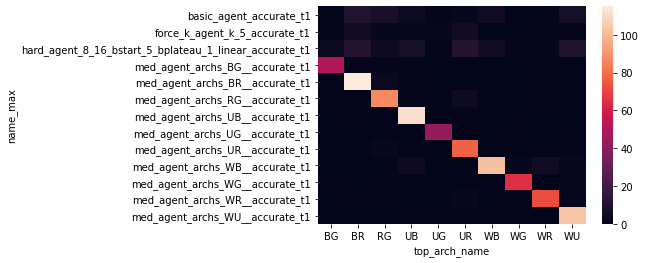

In [26]:
sns.heatmap(df_results.groupby(['name_max',
'top_arch_name'])['id'].count().reset_index().pivot(index='name_max'
,columns='top_arch_name',values='id').fillna(0))
plt.show()

As would be expected, the medium agents tend to match best in pools where the dominant archetype in the pool is the same as the archetype instantiated by the agent. 

 There is marginal activity in the best archetypes (e.g. BR) for the basic and hard agent as well. This is also expected on the basis that the hard agent/basic agent both consider the overall value of the card relative to the pool; if cards for a given arch have higher values on average, then they would be more likely to be selected earlier and then continually selected since cards of that archetype already exist in the pools. 

In [27]:
df_results.groupby(['top_arch_name','name_max']).agg({
"winrate":['min','max','mean',"median"],
"id":'count',
}).head(50)

winrate  \
                                                                       min   
top_arch_name name_max                                                       
BG            force_k_agent_k_5_accurate_t1                       0.400000   
              hard_agent_8_16_bstart_5_bplateau_1_linear_accu...  0.500000   
              med_agent_archs_BG__accurate_t1                     0.000000   
              med_agent_archs_RG__accurate_t1                     0.400000   
              med_agent_archs_WG__accurate_t1                     0.750000   
BR            basic_agent_accurate_t1                             0.250000   
              force_k_agent_k_5_accurate_t1                       0.000000   
              hard_agent_8_16_bstart_5_bplateau_1_linear_accu...  0.000000   
              med_agent_archs_BG__accurate_t1                     0.400000   
              med_agent_archs_BR__accurate_t1                     0.000000   
              med_agent_archs_UB__accurate_t1                     0.500000   
              med_agent_archs_WR__accurate_t1                     0.400000   
RG            basic_agent_accurate_t1                             0.000000   
              force_k_agent_k_5_accurate_t1                       0.571429   
              hard_agent_8_16_bstart_5_bplateau_1_linear_accu...  0.250000   
              med_agent_archs_BG__accurate_t1                     0.500000   
              med_agent_archs_BR__accurate_t1                     0.400000   
              med_agent_archs_RG__accurate_t1                     0.000000   
              med_agent_archs_UR__accurate_t1                     0.400000   
              med_agent_archs_WG__accurate_t1                     0.571429   
              med_agent_archs_WR__accurate_t1                     0.500000   
UB            basic_agent_accurate_t1                             0.000000   
              force_k_agent_k_5_accurate_t1                       0.250000   
              hard_agent_8_16_bstart_5_bplateau_1_linear_accu...  0.000000   
              med_agent_archs_BG__accurate_t1                     0.400000   
              med_agent_archs_BR__accurate_t1                     0.875000   
              med_agent_archs_UB__accurate_t1                     0.000000   
              med_agent_archs_WB__accurate_t1                     0.400000   
              med_agent_archs_WU__accurate_t1                     0.571429   
UG            basic_agent_accurate_t1                             0.875000   
              force_k_agent_k_5_accurate_t1                       0.250000   
              hard_agent_8_16_bstart_5_bplateau_1_linear_accu...  0.777778   
              med_agent_archs_UG__accurate_t1                     0.000000   
              med_agent_archs_WU__accurate_t1                     0.400000   
UR            basic_agent_accurate_t1                             0.400000   
              force_k_agent_k_5_accurate_t1                       0.250000   
              hard_agent_8_16_bstart_5_bplateau_1_linear_accu...  0.000000   
              med_agent_archs_RG__accurate_t1                     0.250000   
              med_agent_archs_UB__accurate_t1                     0.571429   
              med_agent_archs_UG__accurate_t1                     0.000000   
              med_agent_archs_UR__accurate_t1                     0.000000   
              med_agent_archs_WR__accurate_t1                     0.400000   
              med_agent_archs_WU__accurate_t1                     0.625000   
WB            basic_agent_accurate_t1                             0.400000   
              hard_agent_8_16_bstart_5_bplateau_1_linear_accu...  0.000000   
              med_agent_archs_WB__accurate_t1                     0.000000   
              med_agent_archs_WG__accurate_t1                     0.625000   
              med_agent_archs_WU__accurate_t1                     0.250000   
WG            hard_agent_8_16_bstart_5_bplateau_1_linear_accu...  0.400000   
           

In [28]:
#Win rates for 2 color + splash decks (unlikely our bots pull only 2 colors, so a splash would be more representative here; taken from 17lands)
#As we can see as compared to above, the winrates for these decks in the wild tend to beat the winrates of those that we classified under a given archetype. 
# Two-color + Splash	67336	127451	52.8%
# Azorius (WU) + Splash	4083	7940	51.4%
# Dimir (UB) + Splash	6449	12782	50.5%
# Rakdos (BR) + Splash	10558	19503	54.1%
# Gruul (RG) + Splash	10115	18930	53.4%
# Selesnya (GW) + Splash	7118	13626	52.2%
# Orzhov (WB) + Splash	5573	10580	52.7%
# Golgari (BG) + Splash	9358	17604	53.2%
# Simic (GU) + Splash	6797	12830	53.0%
# Izzet (UR) + Splash	4143	7671	54.0%
# Boros (RW) + Splash	3142	5985	52.5%

When looking at the winrates, we tend to see poorer performance in our bots that fall into certain archetypes than the global average (e.g. strategy A in archetype A has a lower winrate than all decks in arch A according to 17lands). Our sample size also diminishes heavily in certain segments, so any time there is an outlier winrate, it appears to be the function of a negligible sample. All of this is to say there does not appear to be a meaningful pattern upon comparing winrates of our strategies in certain archs against the global winrates for those archetypes.

## Experiment #2: Best Medium Bot + 4 other strategies
Since we know that the medium Bot tends to dominate the archetype it was instantiated to prefer, we will remove some medium agents to perform some of the visualizations from above with the other strategies

In [29]:
df_standard = open_index_file_and_preprocess(dirpath+"index_data/VOM_weights_seen_rates_1000_Standard.csv", dirpath+"weights_data/source_weights/VOM_Weights_default__seen_rates_df.csv")

In [30]:
#Here we have the same bots from above plus greedy and less many noisy medium agents
get_accuracy_scores(df_standard,1)

med_agent_archs_BR__accurate_t1                           0.360651
Greedy Agent_turns_greedy_0_accurate_t1                   0.424579
hard_agent_8_16_bstart_5_bplateau_1_linear_accurate_t1    0.508735
force_k_agent_k_1_accurate_t1                             0.456615
basic_agent_accurate_t1                                   0.519623
dtype: float64


In [31]:
df_standard_grouped = get_grouped_accuracy_df(df_standard,dump,cutoff=1,as_percent=True)

In [32]:
#When we look at accuracies by top strategy, we see that subsetting the drafts increases accuracy
#this makes sense since we are taking the times that a given agent performs best and averageing those instances
#Hard and Basic tend to be the most common strategies
df_standard_grouped.groupby('name_max').agg({'name_max':'count',
"rowmax": ['min','max','mean']})

name_max    rowmax  \
                                                      count       min   
name_max                                                                
Greedy Agent_turns_greedy_0_accurate_t1                  70  0.261905   
basic_agent_accurate_t1                                 276  0.238095   
force_k_agent_k_1_accurate_t1                            88  0.261905   
hard_agent_8_16_bstart_5_bplateau_1_linear_accu...      388  0.214286   
med_agent_archs_BR__accurate_t1                         162  0.357143   

                                                                        
                                                         max      mean  
name_max                                                                
Greedy Agent_turns_greedy_0_accurate_t1             0.666667  0.489796  
basic_agent_accurate_t1                             0.833333  0.540890  
force_k_agent_k_1_accurate_t1                       0.761905  0.507305  
hard_agent_8_16_bstart_5_bplateau_1_linear_accu...  0.785714  0.518041  
med_agent_archs_BR__accurate_t1                     0.857143  0.619048

In [33]:
#In this cell, we will replace the index of the pick with a color and find the most common arch/#cards in teh most common arch per draft id
archetypes = ['WU','WB','WR','WG','UB','UR','UG','BR','BG','RG']
df_standard_grouped_archs= df.groupby('id')[archetypes].sum().reset_index()
df_standard_grouped_archs.iloc[:,1:]
df_standard_grouped_archs['top_arch_count'] = df_standard_grouped_archs.iloc[:,-11:].max(axis=1)/42
df_standard_grouped_archs['top_arch_name'] = df_standard_grouped_archs.iloc[:,-11:].idxmax(axis=1)

In [34]:
proc_weights = pd.read_csv(dirpath+'weights_data/processed_weights/VOM_weights_seen_rates.csv')
#Below is the order of archetypes in the weight file

# 'Seen_rate_WU', 'Seen_rate WB', 'Seen_rate WR', 'Seen_rate WG',
#        'Seen_rate UB', 'Seen_rate UR', 'Seen_rate UG', 'Seen_rate BR',
#        'Seen_rate BG', 'Seen_rate RG'

#Based on the order above, we can see that the strongest archetype in the set is positiion 7 (which is BR)
proc_weights.sum()

0    33.468085
1    32.890046
2    17.753898
3    20.672841
4    31.375662
5    26.148927
6    12.371192
7    48.343629
8    17.839027
9    35.606125
dtype: float64

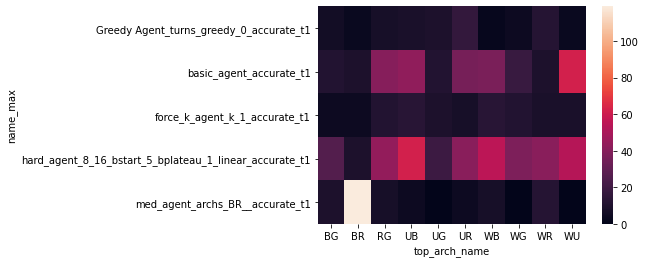

In [35]:
df_standard_results = df_standard_grouped_archs.merge(df_standard_grouped,'inner','id')
sns.heatmap(df_standard_results.groupby(['name_max',
'top_arch_name'])['id'].count().reset_index().pivot(index='name_max'
,columns='top_arch_name',values='id').fillna(0))
plt.show()

Again, the medium archetype agent dominates the archetype that it is targetting (BR). The effect here is that we do not know how prevalent the BR archetype is for the other strategies because the medium agent swallows virtually all of those drafts up. Forcing and greedy agents tend to get few uses across the board and the hottest archetypes for the hard agent and basic agent are those that are in the top half of archetypes by strength (e.g. these agents matched archetypes that are stronger than average, which makes sense given the argument above for the medium experiment).

In [36]:
df_standard_results.groupby(['top_arch_name','name_max']).agg({
"winrate":['min','max','mean',"median"],
"id":'count',
})

winrate  \
                                                                     min   
top_arch_name name_max                                                     
BG            Greedy Agent_turns_greedy_0_accurate_t1               0.00   
              basic_agent_accurate_t1                               0.00   
              force_k_agent_k_1_accurate_t1                         0.00   
              hard_agent_8_16_bstart_5_bplateau_1_linear_accu...    0.00   
              med_agent_archs_BR__accurate_t1                       0.00   
BR            Greedy Agent_turns_greedy_0_accurate_t1               0.25   
              basic_agent_accurate_t1                               0.25   
              force_k_agent_k_1_accurate_t1                         0.00   
              hard_agent_8_16_bstart_5_bplateau_1_linear_accu...    0.00   
              med_agent_archs_BR__accurate_t1                       0.00   
RG            Greedy Agent_turns_greedy_0_accurate_t1               0.00   
              basic_agent_accurate_t1                               0.00   
              force_k_agent_k_1_accurate_t1                         0.00   
              hard_agent_8_16_bstart_5_bplateau_1_linear_accu...    0.00   
              med_agent_archs_BR__accurate_t1                       0.25   
UB            Greedy Agent_turns_greedy_0_accurate_t1               0.00   
              basic_agent_accurate_t1                               0.00   
              force_k_agent_k_1_accurate_t1                         0.00   
              hard_agent_8_16_bstart_5_bplateau_1_linear_accu...    0.00   
              med_agent_archs_BR__accurate_t1                       0.25   
UG            Greedy Agent_turns_greedy_0_accurate_t1               0.25   
              basic_agent_accurate_t1                               0.40   
              force_k_agent_k_1_accurate_t1                         0.25   
              hard_agent_8_16_bstart_5_bplateau_1_linear_accu...    0.00   
UR            Greedy Agent_turns_greedy_0_accurate_t1               0.00   
              basic_agent_accurate_t1                               0.00   
              force_k_agent_k_1_accurate_t1                         0.00   
              hard_agent_8_16_bstart_5_bplateau_1_linear_accu...    0.00   
              med_agent_archs_BR__accurate_t1                       0.00   
WB            Greedy Agent_turns_greedy_0_accurate_t1               0.25   
              basic_agent_accurate_t1                               0.00   
              force_k_agent_k_1_accurate_t1                         0.00   
              hard_agent_8_16_bstart_5_bplateau_1_linear_accu...    0.00   
              med_agent_archs_BR__accurate_t1                       0.25   
WG            Greedy Agent_turns_greedy_0_accurate_t1               0.00   
              basic_agent_accurate_t1                               0.00   
              force_k_agent_k_1_accurate_t1                         0.25   
              hard_agent_8_16_bstart_5_bplateau_1_linear_accu...    0.00   
WR            Greedy Agent_turns_greedy_0_accurate_t1               0.25   
              basic_agent_accurate_t1                               0.25   
              force_k_agent_k_1_accurate_t1                         0.25   
              hard_agent_8_16_bstart_5_bplateau_1_linear_accu...    0.00   
              med_agent_archs_BR__accurate_t1                       0.00   
WU            Greedy Agent_turns_greedy_0_accurate_t1               0.00   
              basic_agent_accurate_t1                               0.00   
              force_k_agent_k_1_accurate_t1                         0.00   
              hard_agent_8_16_bstart_5_bplateau_1_linear_accu...    0.00   

                                                                            \
                                                                       max   
top_arch_name name_max                                                       
BG            Greedy Agent_tur

In [37]:
#Win rates for 2 color + splash decks (unlikely our bots pull only 2 colors, so a splash would be more representative here; taken from 17lands)
# Two-color + Splash	67336	127451	52.8%
# Azorius (WU) + Splash	4083	7940	51.4%
# Dimir (UB) + Splash	6449	12782	50.5%
# Rakdos (BR) + Splash	10558	19503	54.1%
# Gruul (RG) + Splash	10115	18930	53.4%
# Selesnya (GW) + Splash	7118	13626	52.2%
# Orzhov (WB) + Splash	5573	10580	52.7%
# Golgari (BG) + Splash	9358	17604	53.2%
# Simic (GU) + Splash	6797	12830	53.0%
# Izzet (UR) + Splash	4143	7671	54.0%
# Boros (RW) + Splash	3142	5985	52.5%

When we look at winrates by strategy and archetype, we see a few cases where winrates for a given strategy and archetype are marginally better than the global winrates in the cell above. However, we tend to lack a high enough number of instances to make an argument that players that fell into these strategies tended to do better in a given archetype.

## Takeaways

- Classifying drafts by archetype is difficult to analyze in the presence of medium bots that take archetypes that align with those that they prefer
- There is not anything substantial when pulling in win rates and comparing them to global values by archetype (e.g. of all the hard drafts, we cannot conclusively say that hard drafts that end up in archetype X tend to belong to players with higher winrates)
- Switching from an angle of optimizing the bots' accuracies/looking for patterns with player attributes to assessing equilibrium experiments (e.g. effect of playing at a table with 7 basic agents and 1 medium agent) may provide more meaningful outcomes.
